Loaded: (169766, 12)
Batteries: 4 ['B0005' 'B0006' 'B0007' 'B0018']
Type counts:
 type
discharge    169766
Name: count, dtype: int64
Wide feature table: (636, 48)
Capacity source: discharge-like types: ['discharge']
Final cycle_df: (636, 51) | Batteries: 4
Features: 159 | Samples: 556

=== GLOBAL (LOGO) ===
                      Model        MAE        RMSE          R2
1                ElasticNet   1.413395    1.569974    0.975554
4    ExtraTrees_Regularized   1.303680    2.639164    0.930920
2          HistGB_EarlyStop   1.671353    3.051612    0.907641
3  RandomForest_Regularized   2.027525    3.172076    0.900205
0              BaselineMean   8.830220   10.849891   -0.167539
5   NeuralNet_MLP_EarlyStop  80.578966  125.184826 -154.426089

=== PER-BATTERY (LOGO) ===
                       Model Battery         MAE        RMSE          R2
0               BaselineMean   B0005    8.418482    9.990405   -0.091273
1               BaselineMean   B0006   12.716764   14.539713   -0.897670
2  

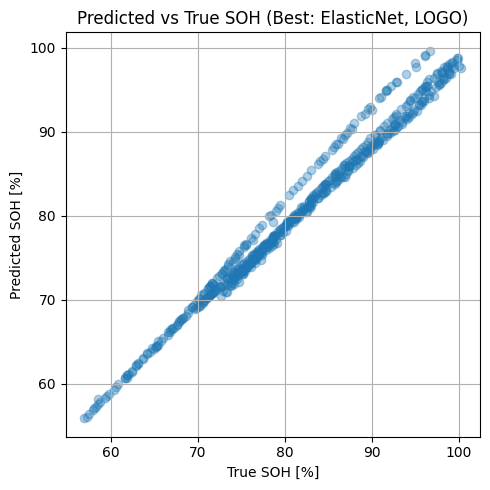

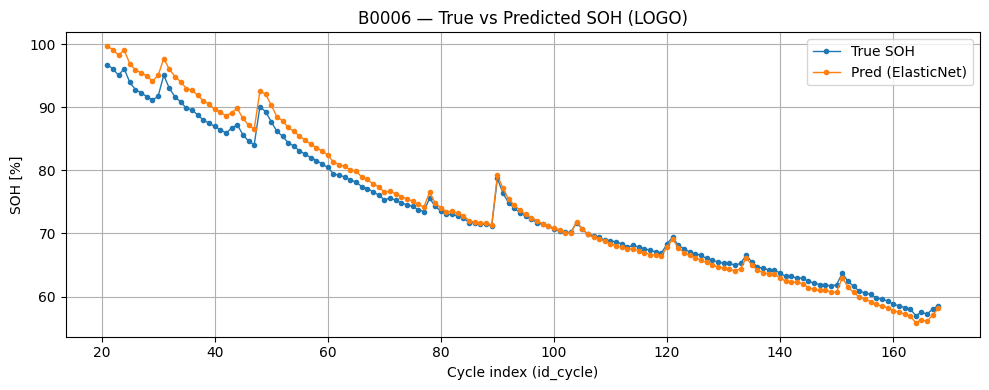


Saved outputs under: outputs_passau_nasa_global_final


In [6]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


# ---------------------------
# 0) CONFIG
# ---------------------------
DATA_PATH = r"/Users/nima/Documents/Disk E/ML/DATA/Battery Aging/uncleaned Nasa Battery Data/discharge.csv"
OUT_DIR = "outputs_passau_nasa_global_final"
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM_STATE = 42

# SOH baseline C0 per battery
C0_FIRST_K_CYCLES = 10
C0_TOP_N = 3

# Feature enrichment
BASE_CYCLES = 5      # for baseline-delta features
DIFF_W = 20          # drift window (diff across DIFF_W cycles)

# Plot battery of interest
PLOT_BATTERY = "B0006"


# ---------------------------
# 1) LOAD + VALIDATE
# ---------------------------
df = pd.read_csv(DATA_PATH)

battery_col = "Battery"
cycle_col   = "id_cycle"
type_col    = "type"

cap_col     = "Capacity"
time_col    = "Time"

# Candidate signals (not all must exist)
signal_cols = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Voltage_charge",
    "Current_charge",
    "ambient_temperature",
]

required = [battery_col, cycle_col, type_col, cap_col, time_col]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

# Convert numeric columns safely
num_cols = [cycle_col, cap_col, time_col] + [c for c in signal_cols if c in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df[type_col] = df[type_col].astype(str)
df = df.dropna(subset=[battery_col, cycle_col, type_col, time_col]).copy()

print("Loaded:", df.shape)
print("Batteries:", df[battery_col].nunique(), df[battery_col].unique())
print("Type counts:\n", df[type_col].value_counts().head(20))


# ---------------------------
# 2) NORMALIZE TYPE NAMES (safe column suffixes)
# ---------------------------
def norm_type(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^a-z0-9_]+", "", s)
    return s if s else "unknown"

df["type_norm"] = df[type_col].map(norm_type)


# ---------------------------
# 3) BUILD FEATURES PER (Battery, cycle, type) THEN PIVOT WIDE
# ---------------------------
def q(p):
    def _q(s): return s.quantile(p)
    _q.__name__ = f"q{int(p*100)}"
    return _q

use_signals = [c for c in signal_cols if c in df.columns]

agg = {
    cap_col:  ["mean"],
    time_col: ["min", "max"],
}
for c in use_signals:
    agg[c] = ["mean", "std", "min", "max", q(0.1), q(0.5), q(0.9)]

grp = [battery_col, cycle_col, "type_norm"]
feat_long = df.groupby(grp).agg(agg)
feat_long.columns = ["__".join([a, b]) for a, b in feat_long.columns]
feat_long = feat_long.reset_index()

# Duration per (battery, cycle, type) segment
feat_long["duration__raw"] = feat_long[f"{time_col}__max"] - feat_long[f"{time_col}__min"]

# Pivot wide -> one row per (Battery, id_cycle)
id_cols = [battery_col, cycle_col]
value_cols = [c for c in feat_long.columns if c not in id_cols + ["type_norm"]]

feat_wide = feat_long.pivot_table(
    index=id_cols,
    columns="type_norm",
    values=value_cols,
    aggfunc="first"
)

feat_wide.columns = [f"{feat}__{t}" for feat, t in feat_wide.columns]
feat_wide = feat_wide.reset_index()

print("Wide feature table:", feat_wide.shape)


# ---------------------------
# 4) CAPACITY PER CYCLE (prefer discharge-like types)
# ---------------------------
types_present = set(df["type_norm"].unique())
discharge_like = [t for t in types_present if ("dis" in t) or ("dch" in t) or ("discharge" in t)]

if discharge_like:
    cap_source = feat_long[feat_long["type_norm"].isin(discharge_like)][
        [battery_col, cycle_col, f"{cap_col}__mean"]
    ].rename(columns={f"{cap_col}__mean": "Capacity_cycle"})
    cap_source = cap_source.groupby([battery_col, cycle_col], as_index=False)["Capacity_cycle"].mean()
    print("Capacity source: discharge-like types:", discharge_like)
else:
    cap_source = df.groupby([battery_col, cycle_col], as_index=False)[cap_col].mean()
    cap_source = cap_source.rename(columns={cap_col: "Capacity_cycle"})
    print("Capacity source: fallback (mean capacity across all types)")

cycle_df = feat_wide.merge(cap_source, on=[battery_col, cycle_col], how="left")
cycle_df = cycle_df.dropna(subset=["Capacity_cycle"]).copy()
cycle_df = cycle_df.sort_values([battery_col, cycle_col]).copy()


# ---------------------------
# 5) SOH LABEL (robust C0 per battery)
# ---------------------------
def compute_c0_map(cycle_df_in: pd.DataFrame) -> dict:
    c0 = {}
    for bid, sub in cycle_df_in.groupby(battery_col):
        sub = sub.sort_values(cycle_col)
        early = sub[sub[cycle_col] < C0_FIRST_K_CYCLES]
        if len(early) == 0:
            early = sub.head(C0_FIRST_K_CYCLES)
        c0[bid] = float(early["Capacity_cycle"].nlargest(C0_TOP_N).mean())
    return c0

c0_map = compute_c0_map(cycle_df)
cycle_df["C0"] = cycle_df[battery_col].map(c0_map)
cycle_df["SOH"] = cycle_df["Capacity_cycle"] / cycle_df["C0"] * 100.0
cycle_df = cycle_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["SOH"]).copy()

print("Final cycle_df:", cycle_df.shape, "| Batteries:", cycle_df[battery_col].nunique())


# ---------------------------
# 6) FEATURE ENRICHMENT: AGE + BASELINE DELTA + DRIFT
# ---------------------------
cycle_df["cycle_idx"] = cycle_df[cycle_col].astype(float)
cycle_df["cycle_frac"] = cycle_df.groupby(battery_col)[cycle_col].transform(lambda s: s / s.max())
cycle_df["log_cycle"] = np.log1p(cycle_df["cycle_idx"])

# Baseline-delta features (per battery, first BASE_CYCLES)
exclude = {battery_col, cycle_col, "Capacity_cycle", "C0", "SOH"}
numeric_feats = [c for c in cycle_df.columns if c not in exclude and pd.api.types.is_numeric_dtype(cycle_df[c])]

base = (cycle_df[cycle_df[cycle_col] < BASE_CYCLES]
        .groupby(battery_col)[numeric_feats].mean())
cycle_df = cycle_df.join(base, on=battery_col, rsuffix="__base")

for c in numeric_feats:
    cycle_df[c + "__delta"] = cycle_df[c] - cycle_df[c + "__base"]

# Drift features: diff over DIFF_W cycles for key signals (if present)
drift_candidates = [c for c in cycle_df.columns if any(k in c for k in [
    "Voltage_measured__mean", "Voltage_charge__mean",
    "Temperature_measured__mean", "duration__raw"
])]
for c in drift_candidates:
    if pd.api.types.is_numeric_dtype(cycle_df[c]):
        cycle_df[c + f"__diff{DIFF_W}"] = cycle_df.groupby(battery_col)[c].diff(DIFF_W)

cycle_df = cycle_df.replace([np.inf, -np.inf], np.nan).dropna().copy()


# ---------------------------
# 7) BUILD MATRICES (IMPORTANT: do NOT include Capacity_cycle)
# ---------------------------
drop_cols = {battery_col, cycle_col, "Capacity_cycle", "C0", "SOH"}
feat_cols = [c for c in cycle_df.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(cycle_df[c])]

X_all = cycle_df[feat_cols]
y_all = cycle_df["SOH"].values
g_all = cycle_df[battery_col].values

print("Features:", len(feat_cols), "| Samples:", len(cycle_df))


# ---------------------------
# 8) MODELS (GLOBAL) + VALIDATION SETTINGS
# ---------------------------
# External validation: LOGO folds.
# Internal validation:
#   - MLPRegressor: early_stopping=True uses a validation_fraction of training fold (sample-level)
#   - HistGradientBoostingRegressor: early_stopping=True uses a validation_fraction of training fold
models = {
    "BaselineMean": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("model", DummyRegressor(strategy="mean"))
    ]),

    "ElasticNet": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", ElasticNet(alpha=0.02, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=60000))
    ]),

    "HistGB_EarlyStop": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("model", HistGradientBoostingRegressor(
            random_state=RANDOM_STATE,
            max_depth=6,
            learning_rate=0.05,
            max_iter=2000,              # high upper bound; early stopping will stop earlier
            early_stopping=True,
            validation_fraction=0.2,
            n_iter_no_change=25
        ))
    ]),

    "RandomForest_Regularized": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            n_estimators=1500,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            max_depth=12,               # regularize
            min_samples_leaf=5,         # regularize
            max_features="sqrt"
        ))
    ]),

    "ExtraTrees_Regularized": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("model", ExtraTreesRegressor(
            n_estimators=2000,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            max_depth=14,               # regularize
            min_samples_leaf=5
        ))
    ]),

    "NeuralNet_MLP_EarlyStop": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", MLPRegressor(
            hidden_layer_sizes=(128, 64),
            activation="relu",
            solver="adam",
            alpha=2e-4,
            learning_rate_init=1e-3,
            max_iter=8000,              # upper bound; early stopping will stop earlier
            early_stopping=True,
            validation_fraction=0.2,
            n_iter_no_change=30,
            random_state=RANDOM_STATE
        ))
    ]),
}


# ---------------------------
# 9) LOGO EVALUATION (STRICT) + BALANCED WEIGHTS
# ---------------------------
logo = LeaveOneGroupOut()

def compute_metrics(y_true, y_pred):
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R2": float(r2_score(y_true, y_pred))
    }

global_rows = []
per_rows = []
oof_preds = {}

for name, pipe in models.items():
    oof = np.zeros_like(y_all, dtype=float)

    for train_idx, test_idx in logo.split(X_all, y_all, groups=g_all):
        X_tr, y_tr, g_tr = X_all.iloc[train_idx], y_all[train_idx], g_all[train_idx]
        X_te, y_te, g_te = X_all.iloc[test_idx], y_all[test_idx], g_all[test_idx]
        held_out = g_te[0]

        # Balanced weights so each training battery contributes equally
        counts = pd.Series(g_tr).value_counts()
        w_map = (1.0 / counts).to_dict()
        w = np.array([w_map[g] for g in g_tr], dtype=float)

        # Try passing weights to final estimator (works for RF/ET/Dummy; may not for all estimators)
        try:
            pipe.fit(X_tr, y_tr, model__sample_weight=w)
        except TypeError:
            pipe.fit(X_tr, y_tr)

        pred = pipe.predict(X_te)
        oof[test_idx] = pred

        m = compute_metrics(y_te, pred)
        per_rows.append({"Model": name, "Battery": held_out, **m})

    global_rows.append({"Model": name, **compute_metrics(y_all, oof)})
    oof_preds[name] = oof

global_df = pd.DataFrame(global_rows).sort_values("RMSE")
per_df = pd.DataFrame(per_rows).sort_values(["Model", "Battery"])

print("\n=== GLOBAL (LOGO) ===")
print(global_df)

print("\n=== PER-BATTERY (LOGO) ===")
print(per_df)

global_df.to_csv(os.path.join(OUT_DIR, "global_metrics_LOGO.csv"), index=False)
per_df.to_csv(os.path.join(OUT_DIR, "per_battery_metrics_LOGO.csv"), index=False)

best_model = global_df.iloc[0]["Model"]
print("\nBest model:", best_model)


# ---------------------------
# 10) PLOTS FOR PAPER
# ---------------------------
# Pred vs True scatter (best model)
plt.figure(figsize=(5, 5))
plt.scatter(y_all, oof_preds[best_model], alpha=0.35)
plt.xlabel("True SOH [%]")
plt.ylabel("Predicted SOH [%]")
plt.title(f"Predicted vs True SOH (Best: {best_model}, LOGO)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pred_vs_true_best.png"), dpi=300)
plt.show()

# Battery curve (e.g., B0006)
if PLOT_BATTERY in set(cycle_df[battery_col].unique()):
    plot_df = cycle_df[[battery_col, cycle_col, "SOH"]].copy()
    plot_df["pred"] = oof_preds[best_model]
    sub = plot_df[plot_df[battery_col] == PLOT_BATTERY].sort_values(cycle_col)

    plt.figure(figsize=(10, 4))
    plt.plot(sub[cycle_col], sub["SOH"], marker=".", linewidth=1, label="True SOH")
    plt.plot(sub[cycle_col], sub["pred"], marker=".", linewidth=1, label=f"Pred ({best_model})")
    plt.xlabel("Cycle index (id_cycle)")
    plt.ylabel("SOH [%]")
    plt.title(f"{PLOT_BATTERY} — True vs Predicted SOH (LOGO)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "b0006_curve_best.png"), dpi=300)
    plt.show()

print("\nSaved outputs under:", OUT_DIR)


In [3]:
import math
import numpy as np
import pandas as pd

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1. Load data
# -----------------------------
DATA_PATH = r"/Users/nima/Documents/Disk E/ML/DATA/Battery Aging/uncleaned Nasa Battery Data/discharge.csv"

df = pd.read_csv(DATA_PATH)

# Keep only discharge cycles (for safety, even if all rows already are discharge)
df = df[df["type"] == "discharge"].copy()

# -----------------------------
# 2. Aggregate to cycle level
# -----------------------------
group_cols = ["Battery", "id_cycle"]

agg_dict = {
    "Voltage_measured": ["mean", "std", "min", "max"],
    "Current_measured": ["mean", "std", "min", "max"],
    "Temperature_measured": ["mean", "std", "min", "max"],
    "ambient_temperature": ["mean"],
    "Time": ["min", "max"],
    "Capacity": ["last"],  # Capacity at the end of discharge
}

cycle_df = df.groupby(group_cols).agg(agg_dict)

# Flatten multi-index columns: e.g. ('Voltage_measured','mean') -> 'Voltage_measured_mean'
cycle_df.columns = [
    "_".join([c for c in col if c]) for col in cycle_df.columns.to_flat_index()
]
cycle_df = cycle_df.reset_index()

# Cycle duration from time stamps
cycle_df["cycle_duration"] = cycle_df["Time_max"] - cycle_df["Time_min"]

# -----------------------------
# 3. Define SOH per cycle
# -----------------------------
# For each battery, compute reference capacity C0 as the mean of the top 3
# capacities among the first 10 cycles (to avoid early noise).
C0_dict = {}
for bat, sub in cycle_df.groupby("Battery"):
    early = sub.sort_values("id_cycle")
    early = early[early["id_cycle"] <= 10]
    top3 = early["Capacity_last"].nlargest(3)
    C0 = top3.mean()
    C0_dict[bat] = C0

# Map reference capacity and compute SOH in %
cycle_df["C0"] = cycle_df["Battery"].map(C0_dict)
cycle_df["SOH"] = cycle_df["Capacity_last"] / cycle_df["C0"] * 100.0

# -----------------------------
# 4. Feature matrix
# -----------------------------
feature_cols = [
    # Voltage statistics
    "Voltage_measured_mean",
    "Voltage_measured_std",
    "Voltage_measured_min",
    "Voltage_measured_max",
    # Current statistics
    "Current_measured_mean",
    "Current_measured_std",
    "Current_measured_min",
    "Current_measured_max",
    # Temperature statistics
    "Temperature_measured_mean",
    "Temperature_measured_std",
    "Temperature_measured_min",
    "Temperature_measured_max",
    # Ambient temperature and cycle duration
    "ambient_temperature_mean",
    "cycle_duration",
]

X = cycle_df[feature_cols].values
y = cycle_df["SOH"].values
groups = cycle_df["Battery"].values  # for LOGO: group = battery id

# -----------------------------
# 5. Models
# -----------------------------
models = {
    "LinearRegression": LinearRegression(),
    "ElasticNet":       ElasticNet(random_state=0),
    "RandomForest":     RandomForestRegressor(
        n_estimators=200,
        random_state=0,
        n_jobs=-1,
        max_depth=None,
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=0),
    "ExtraTrees":       ExtraTreesRegressor(
        n_estimators=200,
        random_state=0,
        n_jobs=-1,
        max_depth=None,
    ),
}

logo = LeaveOneGroupOut()

overall_results = {name: {"y_true": [], "y_pred": []} for name in models}
per_battery_results = {name: {} for name in models}

# -----------------------------
# 6. Leave-One-Group-Out CV across batteries
# -----------------------------
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_battery = groups[test_idx][0]

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Collect overall
        overall_results[name]["y_true"].extend(y_test)
        overall_results[name]["y_pred"].extend(y_pred)

        # Collect per battery
        if test_battery not in per_battery_results[name]:
            per_battery_results[name][test_battery] = {"y_true": [], "y_pred": []}
        per_battery_results[name][test_battery]["y_true"].extend(y_test)
        per_battery_results[name][test_battery]["y_pred"].extend(y_pred)

# -----------------------------
# 7. Compute metrics
# -----------------------------
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

print("=== Overall performance (Leave-One-Battery-Out) ===")
print("{:<18s} {:>10s} {:>10s} {:>8s}".format("Model", "MAE", "RMSE", "R2"))
for name, res in overall_results.items():
    yt = np.array(res["y_true"])
    yp = np.array(res["y_pred"])
    mae, rmse, r2 = compute_metrics(yt, yp)
    print("{:<18s} {:10.3f} {:10.3f} {:8.3f}".format(name, mae, rmse, r2))

# Example: detailed breakdown for RandomForest
rf_battery_rows = []
for bat, res in per_battery_results["RandomForest"].items():
    yt = np.array(res["y_true"])
    yp = np.array(res["y_pred"])
    mae, rmse, r2 = compute_metrics(yt, yp)
    rf_battery_rows.append((bat, mae, rmse, r2))

print("\n=== RandomForest per-battery performance ===")
print("{:<8s} {:>10s} {:>10s} {:>8s}".format("Battery", "MAE", "RMSE", "R2"))
for bat, mae, rmse, r2 in rf_battery_rows:
    print("{:<8s} {:10.3f} {:10.3f} {:8.3f}".format(bat, mae, rmse, r2))


=== Overall performance (Leave-One-Battery-Out) ===
Model                     MAE       RMSE       R2
LinearRegression        7.931      9.667    0.223
ElasticNet              3.792      4.462    0.834
RandomForest            2.711      3.666    0.888
GradientBoosting        2.658      3.718    0.885
ExtraTrees              2.541      3.686    0.887

=== RandomForest per-battery performance ===
Battery         MAE       RMSE       R2
B0005         2.083      2.326    0.949
B0006         5.112      6.094    0.759
B0007         1.707      1.998    0.945
B0018         1.731      2.351    0.921
